In [1]:
# Install necessary libraries.
!pip install opencv-python pyyaml scikit-learn tqdm

**Mounting to google drive.**

In [2]:
# Connecting to google drive.

import os
from google.colab import drive

# Define the base path for your Google Drive.
base_path = '/content/drive'

# Define the specific folder path within your Google Drive.
folder_path = 'MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project'

# Combine the base path and folder path to create the full mount path.
full_project_path = os.path.join(base_path, folder_path)

# Mount your drive.
drive.mount(base_path, force_remount=True)

Mounted at /content/drive


**Functions for preprocessing.**

In [6]:
import cv2
import yaml
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

# Functions for preprocessing data.

def checkThenCreateDirectories(dataset_path: list[str]):
    for path in dataset_path:
        if not os.path.exists(path):
            print(f"Creating directory: {path}")
            os.makedirs(path)
        else:
            print(f"Directory already exists: {path}")
    print("All directories checked/created successfully.\n")

def cudaIsAvailable():
  count = cv2.cuda.getCudaEnabledDeviceCount()
  if count > 0:
    print(f"Number of CUDA-enabled devices: {count}")
    print("CUDA is available!")
    return True
  else:
    print(f"Number of CUDA-enabled devices: {count}")
    print("CUDA is not available...")
    return False

CUDA_ENABLED = cudaIsAvailable()

def processDataset(dataset_path : str, output_path : str):
    # Check if the dataset path exists.
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path {dataset_path} does not exist.")

    # Check if the output path exists.
    if not os.path.exists(output_path):
        raise FileNotFoundError(f"Output path {output_path} does not exist.")

    # Create the output directory if it doesn't exist.
    os.makedirs(output_path, exist_ok=True)

    # Time to process the dataset.
    print(f"Gathering the dataset from: {dataset_path}...\n")
    print(f"And storing it in: {output_path}.\n")

    # Load annotations (e.g., from gt.yml)
    with open(os.path.join(dataset_path, "gt.yml"), "r") as f:
        annotations = yaml.safe_load(f)

    # Collect all image IDs
    img_ids = list(annotations.keys())

    # Split into train and val sets
    train_ids, val_ids = train_test_split(img_ids, test_size=0.2, random_state=42)

    # Sorting.
    train_ids.sort()
    val_ids.sort()

    # Create directories for the train and val sets.
    new_dirs = ["images", "images/train", "images/val",
            "labels", "labels/train", "labels/val"]
    dirs = [os.path.join(output_path, d) for d in new_dirs]

    # Check if the directories exist and create them if they don't.
    checkThenCreateDirectories(dirs)

    # Process each image and its corresponding annotations.
    # For each image ID, we will:
    # 1. Read the image.
    # 2. Save the image in the appropriate directory (train/val).
    # 3. Read the annotations and save them in YOLO format in the appropriate directory (train/val).
    # 4. Print the progress.
    for split, ids in [("train", train_ids), ("val", val_ids)]:
        print(f"------Processing {split} images------")
        for img_id in tqdm(ids,
                             desc=f"Processing {split} images",
                             leave=False,
                             unit=" imgs"):

            # Read the image, notice that the folder is called "rgb".
            img_path = os.path.join(dataset_path, "rgb", f"{img_id:04}.png")
            output_img_path = os.path.join(output_path, "images", split, f"{img_id:04}.png")

            if CUDA_ENABLED:
              # Using GPU.
              gpu_img = cv2.cuda_GpuMat()
              gpu_img.upload(cv2.imread(img_path))
              img = gpu_img.download()
              cv2.imwrite(output_img_path, img)
            else:
              # Using CPU.
              img = cv2.imread(img_path)
              cv2.imwrite(output_img_path, img)

            # Get image dimensions.
            img_height, img_width, _ = img.shape

            # Process annotations and save labels in YOLO format.
            # Initialize list to store label lines for this image.
            label_lines = []

            # Get annotations for current image.
            annotations_for_img = annotations[img_id]

            # Found class ids.
            class_ids = list()

            for box in annotations_for_img:
                # Extract bounding box coordinates.
                x_min, y_min, width, height = box['obj_bb']

                # If we're gonna use Ultralytics.
                class_id = box['obj_id']
                if class_id not in class_ids:
                  class_ids.append(class_id)
                class_id = class_ids.index(class_id)

                # Converting into the YOLO format:
                # (center_x, center_y, width, height).
                center_x = (x_min + width / 2) / img_width
                center_y = (y_min + height / 2) / img_height
                width_normalized = width / img_width
                height_normalized = height / img_height

                # Create label line in YOLO format.
                label_lines.append(f"{class_id} {center_x} {center_y} {width_normalized} {height_normalized}")

            # Save labels to file.
            label_file_path = os.path.join(output_path, f"labels/{split}/{img_id:04}.txt")
            with open(label_file_path, "w") as label_file:
                label_file.write("\n".join(label_lines))

    print("\nDataset processing and label generation completed.\n")

def startProcessing(dataset_path, output_path, data_nr=0):
  if data_nr <= 0 or data_nr > 15:
    for folder_nr in range(1, 16):
      if data_nr < 10:
        data_nr = "0" + str(folder_nr)
      else:
        data_nr = str(folder_nr)
      print(f"------Processing dataset {data_nr}------")
      dataset_path = os.path.join(dataset_path, "Linemod_preprocessed/data/" + data_nr)
      output_path = os.path.join(output_path, data_nr)
      processDataset(dataset_path, output_path)
  else:
    if data_nr < 10:
      data_nr = "0" + str(data_nr)
    else:
      data_nr = str(data_nr)
    print(f"------Processing dataset {data_nr}------")
    dataset_path = os.path.join(dataset_path, "Linemod_preprocessed/data/" + data_nr)
    output_path = os.path.join(output_path, data_nr)
    processDataset(dataset_path, output_path)


Number of CUDA-enabled devices: 0
CUDA is not available...


**Try the preprocessing algorithm.**

In [7]:
# Run the preprocessing algorithm.
dataset_path = os.path.join(full_project_path, "dataset/LineMOD")
output_path = os.path.join(full_project_path, "preprocessed_dataset")

dataset_nr = 2 # Select what dataset you want to process.
startProcessing(dataset_path, output_path, data_nr=dataset_nr)

------Processing dataset 02------
Gathering the dataset from: /content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/dataset/LineMOD/Linemod_preprocessed/data/02...

And storing it in: /content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02.

Creating directory: /content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/images
Creating directory: /content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/images/train
Creating directory: /content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/images/val
Creating directory: /content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/labels
Creating directory: /content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/labels/train

------Processing val images------



Dataset processing and label generation completed.



**Check if things are looking alright.**

In [10]:
import random

def check_preprocessing(output_path, num_examples=1, dataset_nr=1):
  if dataset_nr < 10:
    dataset_str = "0" + str(dataset_nr)
  else:
    dataset_str = str(dataset_nr)
  print(f"Checking preprocessing for dataset {dataset_str}.")
  # Check if the main directories exist.
  required_dirs = [f"{dataset_str}/images",
                   f"{dataset_str}/images/train",
                   f"{dataset_str}/images/val",
                   f"{dataset_str}/labels",
                   f"{dataset_str}/labels/train",
                   f"{dataset_str}/labels/val"]
  for dir_name in required_dirs:
    dir_path = os.path.join(output_path, dir_name)
    if not os.path.exists(dir_path):
      print(f"Error: Directory {dir_path} does not exist.")
      return False

  # Check if the number of images and labels match in each split and print examples
  for split in ["train", "val"]:
    image_dir = os.path.join(output_path, f"{dataset_str}/images", split)
    label_dir = os.path.join(output_path, f"{dataset_str}/labels", split)

    num_images = len(os.listdir(image_dir))
    num_labels = len(os.listdir(label_dir))

    if num_images != num_labels:
      print(f"Error: Number of images and labels do not match in {split} split.")
      print(f"  Images: {num_images}, Labels: {num_labels}")
      return False

    # Print examples
    print(f"\nExamples from {split} split:")
    image_files = os.listdir(image_dir)
    label_files = os.listdir(label_dir)

    for _ in range(min(num_examples, num_images)):  # Limit examples to available files
        random_index = random.randint(0, len(image_files) - 1)  # Choose random index
        image_file = image_files[random_index]
        label_file = label_files[random_index]  # Assuming corresponding label file has the same name

        print(f"  Image: {image_file}, Label: {label_file}")

  print("\nPreprocessing check: All directories and files seem to be in place.")
  return True

# Call the check_preprocessing function after preprocessing is done.
#dataset_nr = 2 # Select what dataset you want to check.
if check_preprocessing(output_path, num_examples=10, dataset_nr=dataset_nr):
  print("Preprocessing completed successfully!")
else:
  print("Preprocessing encountered errors. Please check the output.")

Checking preprocessing for dataset 02.

Examples from train split:
  Image: 0495.png, Label: 0495.txt
  Image: 1039.png, Label: 1039.txt
  Image: 0859.png, Label: 0859.txt
  Image: 0402.png, Label: 0402.txt
  Image: 1103.png, Label: 1103.txt
  Image: 1194.png, Label: 1194.txt
  Image: 0028.png, Label: 0028.txt
  Image: 0399.png, Label: 0399.txt
  Image: 0798.png, Label: 0798.txt
  Image: 0817.png, Label: 0817.txt

Examples from val split:
  Image: 0056.png, Label: 0056.txt
  Image: 0914.png, Label: 0914.txt
  Image: 0210.png, Label: 0210.txt
  Image: 0542.png, Label: 0542.txt
  Image: 0209.png, Label: 0209.txt
  Image: 0427.png, Label: 0427.txt
  Image: 0739.png, Label: 0739.txt
  Image: 0665.png, Label: 0665.txt
  Image: 1166.png, Label: 1166.txt
  Image: 0941.png, Label: 0941.txt

Preprocessing check: All directories and files seem to be in place.
Preprocessing completed successfully!


**Try to plot some random images together with their corresponding boundry boxes.**

Displaying random image from train set:

/content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/images/train/1022.png
/content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/labels/train/1022.txt


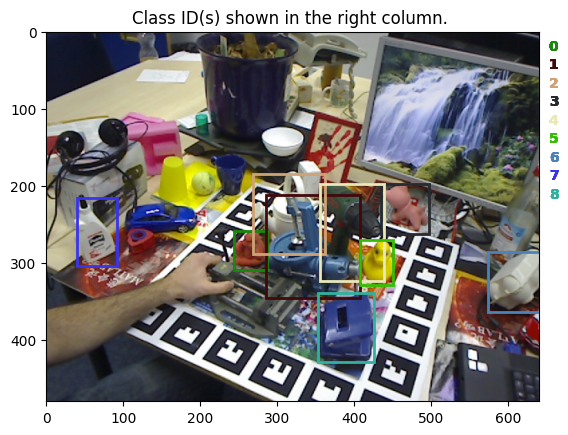


Displaying random image from val set:

/content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/images/val/0220.png
/content/drive/MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project/preprocessed_dataset/02/labels/val/0220.txt


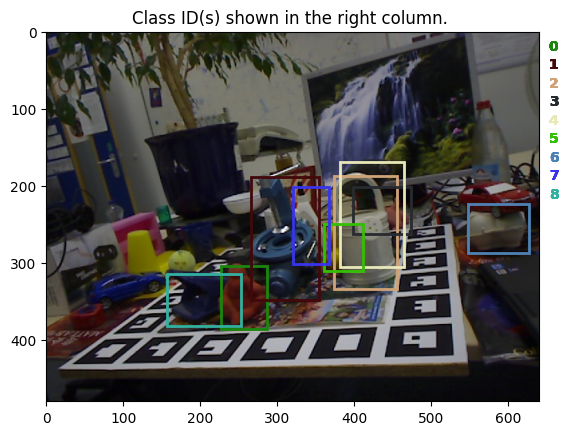

In [13]:
# Try tp print an image and boundry box.
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Generate a dictionary to store colors for each class ID
class_colors = {}

def generate_random_colors(num_colors=1):
  colors = []
  for _ in range(num_colors):
    r = random.random()  # Generate random float between 0 and 1
    g = random.random()
    b = random.random()
    colors.append((r, g, b))  # Use float tuples for RGB
  return colors

def get_color_for_class(class_id):
    # If color for this class ID is not assigned yet, generate and store it
    if class_id not in class_colors:
        class_colors[class_id] = generate_random_colors(1)[0]  # Get a single color
    return class_colors[class_id]

def display_image_with_bboxes(image_path, label_path):
  # Load the image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

  # Load the labels (bounding boxes)
  with open(label_path, 'r') as f:
    bboxes = []
    class_ids = []
    for line in f:
      values = line.strip().split()
      class_id = int(values[0])  # Convert class ID to integer
      x_center, y_center, width, height = map(float, values[1:])  # Keep others as floats
      bboxes.append([x_center, y_center, width, height])
      class_ids.append(class_id)

  # Creating a tuple.
  bboxes_classes_colors = tuple(zip(bboxes, class_ids))

  # Create a figure and axes
  fig, ax = plt.subplots(1)

  # Display the image
  ax.imshow(img)

  # Add bounding boxes to the image.
  for entry in bboxes_classes_colors:
    x_center, y_center, width, height = entry[0]
    class_id = entry[1]  # Get the class ID
    color = get_color_for_class(class_id)
    # Convert normalized coordinates to pixel coordinates.
    x = int((x_center - width / 2) * img.shape[1])
    y = int((y_center - height / 2) * img.shape[0])
    w = int(width * img.shape[1])
    h = int(height * img.shape[0])

    # Create a rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')

    # Add the patch to the axes
    ax.add_patch(rect)

    # Create title with colored class IDs using annotations
    if class_ids:
        title_text = "Class ID(s) shown in the right column. "
        x_offset = 1.02  # Initial x-offset for annotation placement
        y_offset = 0.95  # Start annotation slightly above the image

        # Iterate to annotate each class ID and adjust y_offset
        for i, (class_id, color) in enumerate(zip(class_ids, [get_color_for_class(class_id) for class_id in class_ids])): # Generate color for each class_id
            # Place each annotation on a new line above the image
            plt.annotate(str(class_id), xy=(x_offset, y_offset - i*0.05),
                        xycoords='axes fraction', ha='left', color=color, fontweight='bold')

        plt.title(title_text)

  # Show the plot
  plt.show()

def displayRandomImg(output_path, dataset_nr=1):
  if dataset_nr < 10:
    dataset_str = "0" + str(dataset_nr)
  else:
    dataset_str = str(dataset_nr)
  # Select a random image from the train set.
  train_image_dir = os.path.join(output_path, f"{dataset_str}/images", "train")
  train_label_dir = os.path.join(output_path, f"{dataset_str}/labels", "train")
  random_train_image = random.choice(os.listdir(train_image_dir))
  image_path = os.path.join(train_image_dir, random_train_image)
  label_path = os.path.join(train_label_dir, random_train_image.replace(".png", ".txt"))

  print("Displaying random image from train set:\n")
  print(image_path)
  print(label_path)
  display_image_with_bboxes(image_path, label_path)

  # Select a random image from the val set.
  val_image_dir = os.path.join(output_path, f"{dataset_str}/images", "val")
  val_label_dir = os.path.join(output_path, f"{dataset_str}/labels", "val")
  random_val_image = random.choice(os.listdir(val_image_dir))
  image_path = os.path.join(val_image_dir, random_val_image)
  label_path = os.path.join(val_label_dir, random_val_image.replace(".png", ".txt"))

  print("\nDisplaying random image from val set:\n")
  print(image_path)
  print(label_path)
  display_image_with_bboxes(image_path, label_path)

# Show some random images to check.
#dataset_nr = 2 # Select what dataset you want to check.
displayRandomImg(output_path, dataset_nr=dataset_nr)